In [1]:
!hostname

c0906a-s11.ufhpc


In [2]:
%load_ext autoreload
%autoreload 2

from utils import *

In [3]:
import scripts.notebooks.analysis.nanohh4b as nanohh4b

In [4]:
analysis = nanohh4b.Analysis.load(
    model='/home/ekoenig/analysis/weaver-multiH/models/feynnet_lightning/nanoHH4b/sixjet/training-data-scan/lightning_logs/version_11881857',
    no_bkg=True,
    only=['build_bkg_model']
    )
analysis.run()

0:00:00 [running ] init()


  0%|          | 0/1 [00:00<?, ?it/s]

Using local path: /cmsuf/data/store/user/ekoenig/root/eosuser.cern.ch/eos/user/e/ekoenig/Ntuples/NanoHH4b/run2/mindiag_2018_0L/mc/ggHH4b_tree.root


  0%|          | 0/1 [00:00<?, ?it/s]

Using local path: /cmsuf/data/store/user/ekoenig/root/eosuser.cern.ch/eos/user/e/ekoenig/Ntuples/NanoHH4b/run2/mindiag_2018_0L/data/jetht_tree.root


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


0:00:09 [  done  ] 0:00:09
        [running ] apply_trigger()
        [  done  ] 0:00:00
        [running ] set_bdisc_threshold(signal, bkg, data)
        [  done  ] 0:00:00
        [running ] load_feynnet(signal, bkg, data)


f_evaluate_feynnet: 100%|██████████| 2/2 [01:52<00:00, 56.16s/it]


0:02:02 [  done  ] 0:01:52
        [running ] load_spanet(signal, bkg, data)
        [  done  ] 0:00:00
        [running ] hh_mass_cut(signal, bkg, data)
        [  done  ] 0:00:00
        [disabled] plot_jet_multiplicity(signal, bkg, data)
        [disabled] plot_reco_eff(signal)
        [disabled] plot_higgs(signal, bkg)
        [disabled] plot_region_vars(signal, bkg)
        [disabled] print_4btag_yields(signal, bkg, data)
        [disabled] plot_4b_control(signal, bkg, data)
        [disabled] print_3btag_yields(signal, bkg, data)
        [disabled] plot_3b_control(signal, bkg, data)
        [running ] blind_data(data)
0:02:06 [  done  ] 0:00:04
        [disabled] print_abcd_yields(signal, bkg, data)
        [disabled] plot_3btag_datamc(data, bkg)
        [running ] train_bdt(data)
Loading reweighter from /home/ekoenig/analysis/studies/models/nanoHH4b/private/feynnet/medium/bdt_reweighter.pkl
           --- ABCD jetht Yields ---            
Total: 2.55e+05 (6.70%)                 

In [7]:
import torch

class Dataset(torch.utils.data.Dataset):

    @classmethod
    def load(cls, bkg_x, bkg_w, sig_x, sig_w):
        x = np.concatenate([bkg_x, sig_x])
        y = np.concatenate([np.zeros(len(bkg_x)), np.ones(len(sig_x))])
        w = np.concatenate([bkg_w, sig_w])
        return cls(x, y, w)

    def __init__(self, x, y, w):
        self.x = x
        self.y = y
        self.w = w
        self.n = len(self.x)

        self.indices = np.arange(self.n)
        self.balance_classes()
        self.sample()

    def negative_weights(self, w):
        sumw = w.sum()
        abs_sumw = np.abs(w).sum()
        return np.abs(w) * (sumw / abs_sumw)

    def balance_classes(self):
        self.w[self.y == 0] = self.negative_weights(self.w[self.y == 0])
        self.w[self.y == 1] = self.negative_weights(self.w[self.y == 1])

        bkg_sumw = self.w[self.y == 0].sum()
        sig_sumw = self.w[self.y == 1].sum()

        self.w = np.where( self.y == 0, self.w / bkg_sumw, self.w / sig_sumw )
        self.w = self.w / self.w.sum()

        print('bkg sumw:', self.w[self.y == 0].sum())
        print('sig sumw:', self.w[self.y == 1].sum())

    def sample(self, n=None):
        if n is None: n = self.n
        self.indices = np.random.choice(self.n, size=n, replace=True, p=self.w)

    def __getitem__(self, i):
        return self.x[self.indices[i]], self.y[self.indices[i]]

    def __len__(self):
        return len(self.indices)

class KFoldDataset(torch.utils.data.Dataset):
    def __init__(self, bkg_x, bkg_w, sig_x, sig_w, k=2, stage='training'):
        self.kfolds = np.arange(k)

        self.x = np.concatenate([bkg_x, sig_x])
        self.w = np.concatenate([bkg_w, sig_w])
        self.y = np.concatenate([np.zeros(len(bkg_x)), np.ones(len(sig_x))])
        self.k = np.concatenate([np.arange(len(bkg_x)) % k, np.arange(len(sig_x)) % k])

        if stage == 'training':
            self.datasets = [ Dataset(self.x[self.k != k], self.y[self.k != k], self.w[self.k != k]) for k in self.kfolds ]
        else:
            self.datasets = [ Dataset(self.x[self.k == k], self.y[self.k == k], self.w[self.k == k]) for k in self.kfolds ]

    def __getitem__(self, i):
        return [ d[i] for d in self.datasets ]
    
    def __len__(self):
        return min([ len(d) for d in self.datasets ])


In [8]:
class DNNClassifier(torch.nn.Module):
    def __init__(self, nfts, layers, ncls):
        super().__init__()

        self.fts_norm = torch.nn.BatchNorm1d(nfts, affine=False)

        self.layers = torch.nn.ModuleList()
        for i, (nin, nout) in enumerate(zip([nfts] + layers[:-1], layers)):
            self.layers.append(torch.nn.Linear(nin, nout))
            self.layers.append(torch.nn.Dropout(0.2))
            self.layers.append(torch.nn.ReLU())

        self.layers.append(torch.nn.Linear(layers[-1], 1))

        # self.layers.append(torch.nn.Softmax(dim=1))
        self.layers.append(torch.nn.Sigmoid())

    def forward(self, x):
        x = self.fts_norm(x)
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
import pytorch_lightning as pl
import torchmetrics
class KFoldClassifier(pl.LightningModule):
    def __init__(self, dataset, layers):
        super().__init__()
        self.kfolds = dataset.kfolds
        self.layers = layers

        nfts = dataset.x.shape[1]
        ncls = len(np.unique(dataset.y))
        self.classifiers = torch.nn.ModuleList([DNNClassifier(nfts, layers, ncls) for _ in self.kfolds ])

        self.auroc = torchmetrics.AUROC('binary')

        self.automatic_optimization = False

    def forward(self, x, k):
        return self.classifiers[k](x).squeeze()
    
    def predict_tree(self, tree):
        x = torch.from_numpy(ak.to_numpy( np.stack( ak.unzip(tree[nanohh4b.bdt_features]), axis=1 ) ))
        x = x.to(device=self.device)

        k = np.arange(len(x)) % len(self.kfolds)

        y_hat = torch.zeros(len(x))
        with torch.no_grad():
            for i in self.kfolds:
                y_hat[k == i] = self(x[k == i], i)

        return y_hat.cpu().numpy()


    def training_step(self, batch, batch_idx):
        optimizers = self.optimizers()

        total_loss = 0
        for i, (x, y) in enumerate(batch):
            opt = optimizers[i]
            opt.zero_grad()

            y_hat = self(x, i)

            # loss = torch.nn.functional.cross_entropy(y_hat, y.long())
            loss = torch.nn.functional.binary_cross_entropy(y_hat, y.float())

            self.log(f'train_loss_{i}', loss)

            self.manual_backward(loss)
            opt.step()

            total_loss += loss
        self.log('train_loss', total_loss)
        return total_loss

    def validation_step(self, batch, batch_idx):
        total_loss = 0
        for i, (x, y) in enumerate(batch):
            y_hat = self(x, i)

            auroc = self.auroc(y_hat, y.long())
            self.log(f'val_auroc_{i}', auroc, prog_bar=True)

            loss = torch.nn.functional.binary_cross_entropy(y_hat, y.float())
            self.log(f'val_loss_{i}', loss)
            total_loss += loss
        self.log('val_loss', total_loss)
        return total_loss

    def configure_optimizers(self):
        return [ torch.optim.Adam(c.parameters(), lr=1e-3) for c in self.classifiers ]


In [10]:
training_dataset = KFoldDataset(bkg_model_x, bkg_model_w, signal_x, signal_w, k=2)
validation_dataset = KFoldDataset(bkg_model_x, bkg_model_w, signal_x, signal_w, k=2, stage='validation')

bkg sumw: 0.5000000000000001
sig sumw: 0.5
bkg sumw: 0.49999999999999994
sig sumw: 0.5
bkg sumw: 0.49999999999999994
sig sumw: 0.5
bkg sumw: 0.5000000000000001
sig sumw: 0.5


In [11]:
dnn = KFoldClassifier(training_dataset, [32, 16])

In [12]:
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=1024, num_workers=4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1024, num_workers=4, pin_memory=True)

In [13]:
earlystopping = pl.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

trainer = pl.Trainer(max_epochs=100, callbacks=[earlystopping])
trainer.fit(dnn, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name        | Type        | Params
--------------------------------------------
0 | classifiers | ModuleList  | 2.4 K 
1 | auroc       | BinaryAUROC | 0     
--------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [14]:
dnn.eval()

KFoldClassifier(
  (classifiers): ModuleList(
    (0): DNNClassifier(
      (fts_norm): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (layers): ModuleList(
        (0): Linear(in_features=20, out_features=32, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): ReLU()
        (3): Linear(in_features=32, out_features=16, bias=True)
        (4): Dropout(p=0.2, inplace=False)
        (5): ReLU()
        (6): Linear(in_features=16, out_features=1, bias=True)
        (7): Sigmoid()
      )
    )
    (1): DNNClassifier(
      (fts_norm): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (layers): ModuleList(
        (0): Linear(in_features=20, out_features=32, bias=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): ReLU()
        (3): Linear(in_features=32, out_features=16, bias=True)
        (4): Dropout(p=0.2, inplace=False)
        (5): ReLU()
        (6): Linear(in_features=16, out_feat

In [15]:
(signal+bkg_model).apply(lambda t : t.extend(dnn_score=dnn.predict_tree(t)))

[None, None]

  0%|          | 0/1 [00:00<?, ?it/s]2023-10-12 08:55:17.591965: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-12 08:55:18.167370: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-12 08:55:18.830902: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-12 08:55:20.754616: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-12 08:55:21.202438: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-12 08:55:21.668414: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
  0%|          | 0/1 [00:00<?, ?it/s]2023-10-12 08:55:35.650802: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2023-10-12 08:55:36.051843: E external/org_tensorflow/tensorflow/compiler/xla/python/p

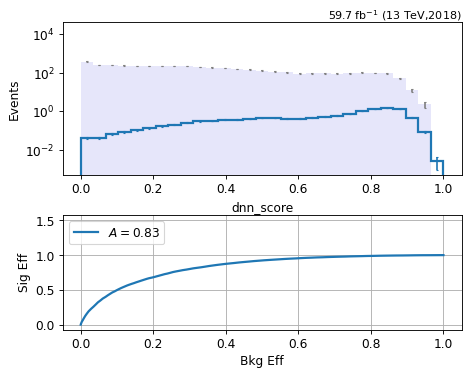

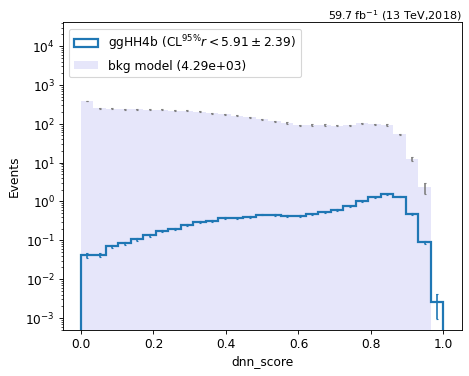

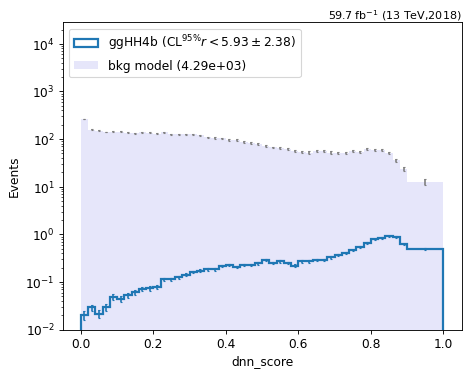

In [16]:
study.quick(
    signal + bkg_model,
    varlist=['dnn_score'],
    binlist=[(0,1,30)],
    log=True, 
    # limits=True, legend=True,

    **study.auroc,
)

study.quick(
    signal + bkg_model,
    varlist=['dnn_score'],
    binlist=[(0,1,30)],
    log=True, 
    limits=True, legend=True,
)

study.quick(
    signal + bkg_model,
    varlist=['dnn_score'],
    binlist=[varinfo.bdt_score.bins],
    log=True, 
    limits=True, legend=True,
)